In [9]:
library(dplyr)
library(readr)
library(tidyr)
library(forcats)
library(janitor)
library(ggplot2)
library(knitr)
library(scales)

In [10]:
# Path
path <- "../"

# Read the data
df <- read_csv(paste0(path, "output/ZX05/PL fix costs.csv"), show_col_types = FALSE ) |>
  clean_names()


# Change data type
df <- df |>
  mutate(across(cost_ctr, as.character))


# Filter primary costs
df <- df |>
  filter(race_item %in% c(
    "PE production",
    "PE materials management",
    "PE plant administration"
  ))

In [11]:
# Select columns
id_cols <- c(
  "cost_ctr",
  "gl_accounts",
  "profit_ctr",
  "fix_var_cc",
  "department",
  "acc_lv2",
  # Add
  "bu",
  "division",
  "plant_name",
  "outlet_name",
  "ce_text",
  "race_item"
)
numeric_cols <- c(
  "plan",
  "actual",
  # "target",
  "delta_to_plan"
)

df <- df |>
  select(all_of(id_cols), all_of(numeric_cols))


# Change sign logic from RACE to SAP & from k LC to LC
df <- df |>
  mutate(
    across(numeric_cols, ~ (.x * -1e+3)),
    across(c("delta_to_plan"), ~ (.x * -1))
  )

## Delta charts

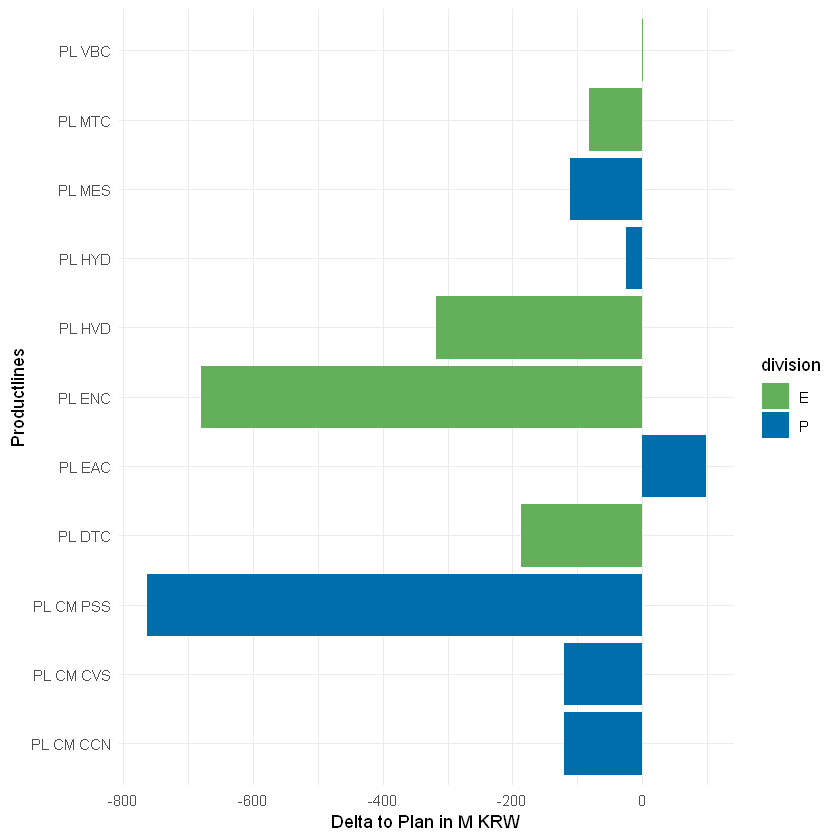

In [12]:
ggplot(
    df,
    aes(
        x = delta_to_plan,
        y = outlet_name,  # fct_reorder(outlet_name, desc(delta_to_plan)),
        fill = division
    )
) + 
    geom_bar(stat = "summary", fun = "sum", position = "stack") +
    scale_x_continuous(labels = label_number(scale = 1 / 1e+6)) +
    scale_fill_manual(values = c("#64AF59", "#006EAA")) +
    labs(x = "Delta to Plan in M KRW", y = "Productlines") +
    theme_minimal()

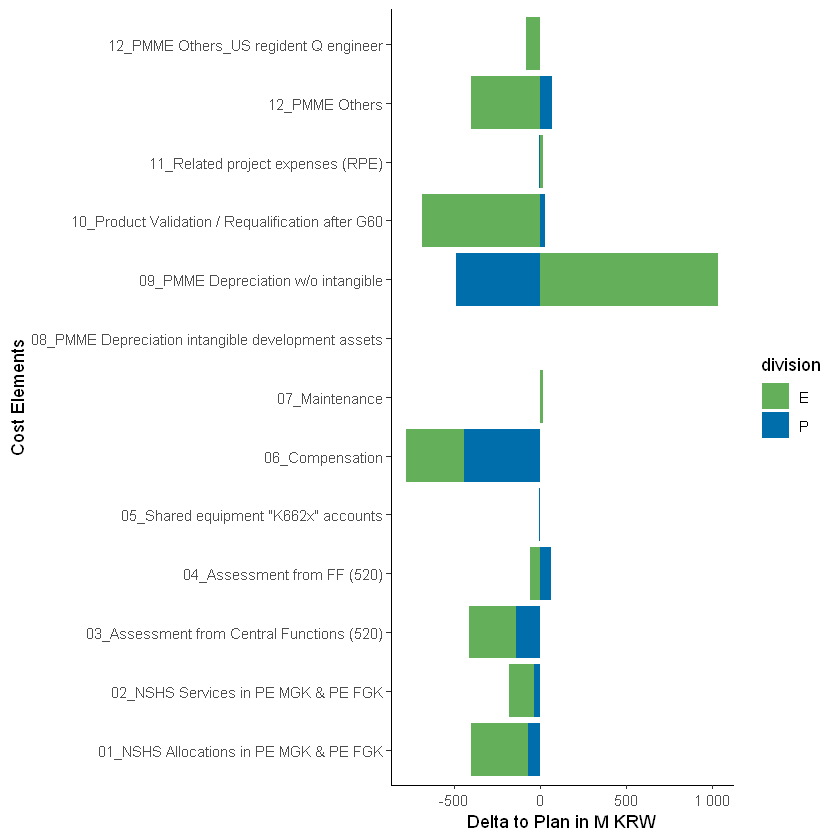

In [13]:
ggplot(
    df,
    aes(
        x = delta_to_plan,
        y = ce_text,
        fill = division
    )
) + 
    geom_bar(stat = "summary", fun = "sum", position = "stack") +
    scale_x_continuous(labels = label_number(scale = 1 / 1e+6)) +
    scale_fill_manual(values = c("#64AF59", "#006EAA")) +
    labs(x = "Delta to Plan in M KRW", y = "Cost Elements") +
    theme_classic()

In [14]:
# Summarize the data ----
df <- df |>
  group_by(pick(id_cols)) |>
  summarise(across(numeric_cols, sum)) |>
  ungroup()

top_10_negative <- df |>
  arrange(delta_to_plan) |>
  slice_head(n = 10)

top_10_positive <- df |>
  arrange(delta_to_plan) |>
  slice_tail(n = 10)

df_sum <- df |>
  group_by() |>
  summarise(across(numeric_cols, sum)) |>
  ungroup()

`summarise()` has grouped output by 'cost_ctr', 'gl_accounts', 'profit_ctr',
'fix_var_cc', 'department', 'acc_lv2', 'bu', 'division', 'plant_name',
'outlet_name', 'ce_text'. You can override using the `.groups` argument.


## Data tables

In [15]:
top_10_negative

cost_ctr,gl_accounts,profit_ctr,fix_var_cc,department,acc_lv2,bu,division,plant_name,outlet_name,ce_text,race_item,plan,actual,delta_to_plan
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
5821,K5305,50803-051,Fix,QM,465 Cost of materials,CT,E,ICH Icheon,PL MTC,10_Product Validation / Requalification after G60,PE production,0,838401386,-838401386
5811,S91003,50803-049,Fix,QM,999 Not allocated,CT,E,ICH Icheon,PL ENC,10_Product Validation / Requalification after G60,PE production,0,383500650,-383500650
4280,K685,50803-047,Fix,Purchasing,465 Cost of materials,DS,E,ICH Icheon,PL HVD,12_PMME Others,PE materials management,-367328692,0,-367328692
5813,S91003,50803-046,Fix,QM,999 Not allocated,HT,P,ICH Icheon,PL CM PSS,10_Product Validation / Requalification after G60,PE production,0,309927144,-309927144
39211,K685,50803-047,Var,Production,465 Cost of materials,DS,E,ICH Icheon,PL HVD,12_PMME Others,PE production,-240077850,0,-240077850
IC-399LM,S87310,50803-049,Fix,Assessment,520 Assessments In,CT,E,ICH Icheon,PL ENC,04_Assessment from FF (520),PE production,0,183328103,-183328103
5821,S91003,50803-051,Fix,QM,999 Not allocated,CT,E,ICH Icheon,PL MTC,10_Product Validation / Requalification after G60,PE production,0,182323465,-182323465
3721,K30001,50803-049,Fix,QM,299 Total Labor Costs,CT,E,ICH Icheon,PL ENC,06_Compensation,PE production,0,155935440,-155935440
IC-99LM,K66271,50803-049,Fix,Shared service,585 Allocation In/Out,CT,E,ICH Icheon,PL ENC,01_NSHS Allocations in PE MGK & PE FGK,PE production,2642211757,2785034322,-142822565


In [16]:
top_10_positive

cost_ctr,gl_accounts,profit_ctr,fix_var_cc,department,acc_lv2,bu,division,plant_name,outlet_name,ce_text,race_item,plan,actual,delta_to_plan
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
31320,K413,50803-051,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL MTC,09_PMME Depreciation w/o intangible,PE production,582137669,442576177,139561492
5824,K6620,50803-047,Fix,QM,535 Services In/Out,DS,E,ICH Icheon,PL HVD,10_Product Validation / Requalification after G60,PE production,166125000,0,166125000
5813,K6620,50803-046,Fix,QM,535 Services In/Out,HT,P,ICH Icheon,PL CM PSS,10_Product Validation / Requalification after G60,PE production,191105436,0,191105436
5816,K6620,50803-045,Fix,QM,535 Services In/Out,HT,P,ICH Icheon,PL CM CCN,10_Product Validation / Requalification after G60,PE production,197667780,0,197667780
3733,S87310,50803-045,Fix,QM,520 Assessments In,HT,P,ICH Icheon,PL CM CCN,04_Assessment from FF (520),PE production,0,-267567636,267567636
3721,S87310,50803-049,Fix,QM,520 Assessments In,CT,E,ICH Icheon,PL ENC,04_Assessment from FF (520),PE production,0,-324831656,324831656
5811,K6620,50803-049,Fix,QM,535 Services In/Out,CT,E,ICH Icheon,PL ENC,10_Product Validation / Requalification after G60,PE production,344590530,0,344590530
5821,K6620,50803-051,Fix,QM,535 Services In/Out,CT,E,ICH Icheon,PL MTC,10_Product Validation / Requalification after G60,PE production,349381416,0,349381416
39013,K413,50803-051,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL MTC,09_PMME Depreciation w/o intangible,PE production,448054329,58333,447995996


In [17]:
bind_rows(df, df_sum)

cost_ctr,gl_accounts,profit_ctr,fix_var_cc,department,acc_lv2,bu,division,plant_name,outlet_name,ce_text,race_item,plan,actual,delta_to_plan
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
31001,K063,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,0,57000,-57000
31001,K0631,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,0,5271,-5271
31001,K413,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,09_PMME Depreciation w/o intangible,PE production,139059897,131609784,7450113
31001,K4431,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,216486,157426,59060
31001,K4451,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,780282,0,780282
31001,K4500,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,649464,159459,490005
31001,K45001,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,0,1543263,-1543263
31001,K4502,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,0,616000,-616000
31001,K4505,50803-049,Var,Production,465 Cost of materials,CT,E,ICH Icheon,PL ENC,12_PMME Others,PE production,0,435720,-435720
